# Document Clustering and Topic Modeling

## Contents

<ul>
<li>[Part 0: Translate Reviews](#Part-0:-Translate-Reviews)
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
<li>[Part 6: Sentiment Analysis](#Part-6:-Sentiment-Analysis)
<li>[Part 7: Comparison K-means and LDA](#Part-7:-Comparison-K-Means-and-LDA)
</ul>

# Part 0: Translate Reviews

In [ ]:
from google.cloud import translate
import os
import csv
import time
import pandas as pd

#setup
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="C:/Users/yebod/Downloads/My Project 61912-be63adc2c36e.json"
li_summary=[]
li_review=[]

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out


def translate_text(text,target='en'):
    print("text is"+text)
    li_original=chunkIt(text,len(text)/800)
    output="";
    print (li_original)


    for i in li_original:
        translate_client = translate.Client()
        print ("i is"+i)
        result = translate_client.translate(i, target_language=target)
        output=output+result['translatedText']
        print ("output is "+ output)
        time.sleep(3)
    return output

with open("review subsample.csv",encoding="utf-8") as csvinput:

    reader = csv.reader(csvinput)
    for row in reader:
        summary_text=row[1]
        li_summary.append(translate_text(summary_text))
        if(row[2]==None):
            li_review.append("")
        else:
            review_text=row[2]
            li_review.append(translate_text(review_text))
        time.sleep(1)

    df = pd.DataFrame(li_review, columns=["review"])
    df.to_csv('wonnai_review.csv',index=False)
    df2=pd.DataFrame(li_summary,columns=["summary"])
    df2.to_csv('wongnai_summary.csv',index=False)

# Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

Read data from files. In summary, we have about 100 thousand user reviews

In [2]:
userReviews=pd.read_csv('../data/translation.txt',sep= '\t',error_bad_lines=False,header=None,usecols=[0,1,2],nrows=5000)
#remove non ascii
userReviews.replace({u'[^\x00-\x7F]+':' '}, regex=True, inplace=True)
userReviews=userReviews.loc[userReviews[2]!=' ']
userReviews= userReviews[userReviews[2].notnull()]
reviews=userReviews[2]


In [3]:
reviews[:10]

0     Delicious everything But not spicy. I do not k...
1     Dumplings mixed to a bit. Overall taste satisf...
2     I will eat many then. The taste is fresh but t...
3     Fly to Hat Yai. If you miss the scene of the S...
4     Shabu here are 2 prices, the price of the shop...
5     Bear hug cafe &#39;on the left hand. Chiang Ma...
6     Spacious I do not know what to do. Medium oatm...
7     Sushi is a very good word, the price is very g...
8     Have a nice Tea Break at &quot;P eony&quot; to...
10    I have to eat the first time on Saturday, beca...
Name: 2, dtype: object

In [4]:
#remove Non Ascii

'''
asciiReviews=[]
for line in reviews:
    line=str(line).strip().decode("ascii","ignore").encode("ascii")
    if line=="":continue
    asciiReviews.append(line)
asciiReviews[0:5]


'''

        

'\nasciiReviews=[]\nfor line in reviews:\n    line=str(line).strip().decode("ascii","ignore").encode("ascii")\n    if line=="":continue\n    asciiReviews.append(line)\nasciiReviews[0:5]\n\n\n'

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [5]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 179 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [6]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);    
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)

    for token in tokens:
        if re.search('[a-zA-Z]', token) and '&' not in token and len(token)>1:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        #word should be composed by alphabets, no use '&', and everything is Ascii.
        if re.search('[a-zA-Z]', token) and '&' not in token and len(token)>1:
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
tokenization_and_stemming("she looked at her father's arm.")

[u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [8]:
docs_stemmed = []
docs_tokenized = []
for i in reviews:
    try:
        tokenized_and_stemmed_results = tokenization_and_stemming(i)
        docs_stemmed.extend(tokenized_and_stemmed_results)

        tokenized_results = tokenization(i)
        docs_tokenized.extend(tokenized_results)
    except:
        print i

In [9]:
docs_tokenized[:10]

['delicious',
 'everything',
 'but',
 'spicy',
 'know',
 'dumplings',
 'mixed',
 'bit',
 'overall',
 'taste']

In [10]:
docs_stemmed[:10]

[u'delici',
 u'everyth',
 u'but',
 u'spici',
 u'know',
 u'dumpl',
 u'mix',
 u'bit',
 u'overal',
 u'tast']

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [11]:
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['delici']

delicious


# Part 3: TF-IDF

In [12]:
#define vectorizer parameters
tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(reviews) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " summaries and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 3781 summaries and 44 terms.


In [13]:
tfidf_matrix[0]

<1x44 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [14]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.1,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [15]:
tf_selected_words = tfidf_model.get_feature_names()

# (Optional) Calculate Document Similarity

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[1.         0.         0.         ... 0.07796803 0.         0.        ]
 [0.         1.         0.25688446 ... 0.09673227 0.         0.20549529]
 [0.         0.25688446 1.         ... 0.39454827 0.         0.09457301]
 ...
 [0.07796803 0.09673227 0.39454827 ... 1.         0.         0.17107341]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.20549529 0.09457301 ... 0.17107341 0.         1.        ]]


In [17]:
cos_matrix

array([[1.        , 0.        , 0.        , ..., 0.07796803, 0.        ,
        0.        ],
       [0.        , 1.        , 0.25688446, ..., 0.09673227, 0.        ,
        0.20549529],
       [0.        , 0.25688446, 1.        , ..., 0.39454827, 0.        ,
        0.09457301],
       ...,
       [0.07796803, 0.09673227, 0.39454827, ..., 1.        , 0.        ,
        0.17107341],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.20549529, 0.09457301, ..., 0.17107341, 0.        ,
        1.        ]])

# Part 4: K-means clustering

In [18]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [19]:
clusters[0:10]

[1, 0, 2, 4, 4, 2, 2, 3, 2, 4]

In [20]:
userReviews['K-Means']=clusters

In [21]:
userReviews[-10:]

,0,1,2,K-Means
4989,164855,The food is delicious and sweet.,The restaurant is delicious food with fish and...,2
4990,164859,Not delicious,"brownie is not good at all, but 20 baht is goo...",4
4991,164872,"Atmosphere available wifi, but not impressed.","The atmosphere is available wifi, but the coff...",0
4992,164882,# 1 of delicious tasting fire !!!!!,I&#39;ve been eating a lot of food lately. I&#...,0
4993,164891,The seafood sauce really cool.,Sea Food Seafood ... delicious flavor of the r...,4
4995,164906,Good atmosphere,Who likes the cozy waterfront? Have a good mea...,3
4996,164912,"Delicious cake, soft tongue Good atmosphere","I like this cake, I like it very delicious cak...",2
4997,164913,"Sausage, pork leg weissbier and yogurt",Bei Otto is a traditional German restaurant. A...,4
4998,164915,Delicious but very much in the daytime. It is ...,Roasted chicken baked eggs hot pan.,0
4999,164928,"Fast service, delicious food full of words.","Today, there are 789 Baht per set, Sweetie Bul...",3


## 4.1. Analyze K-means Result

In [22]:
# create DataFrame films from all of the input files.
frame = pd.DataFrame(clusters , columns = ['cluster'])

In [23]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
0,1242
4,859
2,675
3,539
1,466


In [24]:
print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ",",
    print
    
    
    

<Document clustering result by K-means>
Cluster 0 words: eat, like, restaurant, food, taste, price,
Cluster 1 words: delicious, food, eat, restaurant, taste, like,
Cluster 2 words: shop, restaurant, like, taste, eat, delicious,
Cluster 3 words: good, atmosphere, food, taste, service, delicious,
Cluster 4 words: pork, fried, eat, delicious, shrimp, sauce,


## 4.2. Plot K-means Result

In [25]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

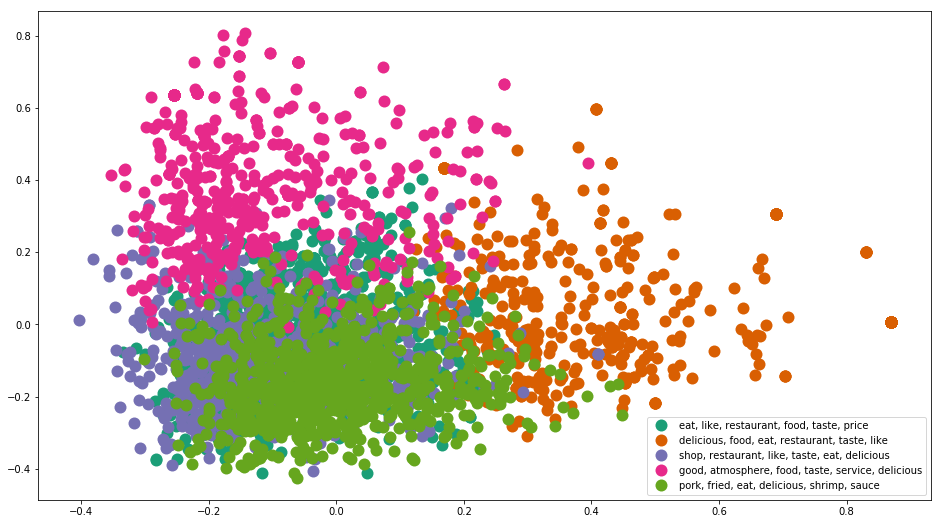

In [26]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [27]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, learning_method = 'online')
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [29]:
lda.fit(tfidf_matrix_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [30]:
#5 group, 44 selected words
topic_word = lda.components_
print topic_word.shape

(5L, 44L)


In [31]:
n_top_words = 10
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [32]:
#3788 docs, and 5 topics
doc_topic = lda.transform(tfidf_matrix_lda)
print doc_topic.shape

(3781L, 5L)


In [33]:
for i in range(5):
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])

Cluster 0 words: eat, like, people, lot, sweet, taste, many, expensive, time
Cluster 1 words: good, food, service, taste, delicious, table, fresh, restauran, time
Cluster 2 words: delicious, pork, fried, rice, dishes, soup, ordered, eat, menu
Cluster 3 words: shop, atmospher, try, menu, sit, drinks, restauran, comes, stores
Cluster 4 words: baht, sauce, price, fish, shrimp, meat, soft, fresh, restauran


In [34]:
list=[i.argmax() for i in doc_topic]

In [35]:
userReviews['LDA']=list
userReviews['topic1_score']=[i[0] for i in doc_topic]
userReviews['topic2_score']=[i[1] for i in doc_topic]
userReviews['topic3_score']=[i[2] for i in doc_topic]
userReviews['topic4_score']=[i[3] for i in doc_topic]
userReviews['topic5_score']=[i[4] for i in doc_topic]

In [36]:
userReviews[0:10]

,0,1,2,K-Means,LDA,topic1_score,topic2_score,topic3_score,topic4_score,topic5_score
0,116604,Delicious food,Delicious everything But not spicy. I do not k...,1,2,0.370792,0.001476,0.624783,0.001478,0.001471
1,173513,Fair enough,Dumplings mixed to a bit. Overall taste satisf...,0,1,0.002023,0.992014,0.001984,0.001992,0.001987
2,190149,Tasty treats But the price is high.,I will eat many then. The taste is fresh but t...,2,0,0.285255,0.209965,0.000750,0.223400,0.280630
3,364779,Dim Sum is proud of Hat Yai.,Fly to Hat Yai. If you miss the scene of the S...,4,3,0.182262,0.000714,0.336832,0.479483,0.000709
4,379746,The best soup is available!,"Shabu here are 2 prices, the price of the shop...",4,2,0.000715,0.000708,0.387443,0.233924,0.377210
5,640755,Fall in love from the first,Bear hug cafe &#39;on the left hand. Chiang Ma...,2,0,0.491330,0.172415,0.000658,0.334953,0.000644
6,677989,I need to know.,Spacious I do not know what to do. Medium oatm...,2,3,0.324709,0.230280,0.000929,0.443159,0.000923
7,695236,Taste cheap.,"Sushi is a very good word, the price is very g...",3,1,0.153062,0.387690,0.184676,0.126345,0.148228
8,2,Have a nice Tea Break at &quot;P eony&quot; to...,Have a nice Tea Break at &quot;P eony&quot; to...,2,3,0.358529,0.052159,0.000515,0.533153,0.055645
10,5,This is the first time that I&#39;ve been on s...,"I have to eat the first time on Saturday, beca...",4,2,0.309896,0.144129,0.357559,0.092051,0.096365


# part6: Sentiment Analysis

In [37]:
#load data from official doc
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
n_instances = 100
subj_docs = [(sent, 'subj') for sent in subjectivity.sents(categories='subj')[:n_instances]]
obj_docs = [(sent, 'obj') for sent in subjectivity.sents(categories='obj')[:n_instances]]
len(subj_docs), len(obj_docs)

(100, 100)

In [38]:
#mark negation
train_subj_docs = subj_docs[:80]
test_subj_docs = subj_docs[80:100]
train_obj_docs = obj_docs[:80]
test_obj_docs = obj_docs[80:100]
training_docs = train_subj_docs+train_obj_docs
testing_docs = test_subj_docs+test_obj_docs

sentim_analyzer = SentimentAnalyzer()
all_words_neg = sentim_analyzer.all_words([mark_negation(doc) for doc in training_docs])


In [39]:
#unigram feats
unigram_feats = sentim_analyzer.unigram_word_feats(all_words_neg, min_freq=4)
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)



In [40]:
unigram_feats[:10]

[u'.', u'the', u',', u'a', u'and', u'of', u'to', u'is', u'in', u'with']

In [41]:
#train and test
test_set = sentim_analyzer.apply_features(testing_docs)
training_set = sentim_analyzer.apply_features(training_docs)

trainer=NaiveBayesClassifier.train
classifier=sentim_analyzer.train(trainer,training_set)

results = sentim_analyzer.evaluate(test_set)

#for key ,value in sorted(sentim_analyzer.evaluate(test_set).items()):
#    print('{0}:{1}'.format(key,value))

Training classifier
Evaluating NaiveBayesClassifier results...


In [42]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
neg,neu,pos,compound=[],[],[],[]
for sentence in userReviews[2]:
    ss = sid.polarity_scores(str(sentence))
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    compound.append(ss['compound'])
    #print("{:-<40} {}".format(sentence, str(ss)))
    #print()

In [43]:
neg[0:10]

[0.0, 0.148, 0.078, 0.045, 0.013, 0.023, 0.058, 0.0, 0.013, 0.032]

In [44]:
userReviews['neg']=neg
userReviews['neu']=neu
userReviews['pos']=pos
userReviews['compound']=compound

In [45]:
userReviews[-10:]

,0,1,2,K-Means,LDA,topic1_score,topic2_score,topic3_score,topic4_score,topic5_score,neg,neu,pos,compound
4989,164855,The food is delicious and sweet.,The restaurant is delicious food with fish and...,2,4,0.000790,0.177014,0.049357,0.367158,0.405681,0.108,0.669,0.223,0.4753
4990,164859,Not delicious,"brownie is not good at all, but 20 baht is goo...",4,4,0.244079,0.159131,0.295739,0.000568,0.300485,0.166,0.706,0.128,-0.3658
4991,164872,"Atmosphere available wifi, but not impressed.","The atmosphere is available wifi, but the coff...",0,1,0.318847,0.556338,0.001134,0.122575,0.001105,0.000,1.000,0.000,0.0000
4992,164882,# 1 of delicious tasting fire !!!!!,I&#39;ve been eating a lot of food lately. I&#...,0,0,0.790487,0.206427,0.001032,0.001028,0.001027,0.042,0.844,0.114,0.4514
4993,164891,The seafood sauce really cool.,Sea Food Seafood ... delicious flavor of the r...,4,2,0.222920,0.082394,0.373799,0.000912,0.319976,0.000,0.704,0.296,0.8955
4995,164906,Good atmosphere,Who likes the cozy waterfront? Have a good mea...,3,0,0.502359,0.493376,0.001420,0.001425,0.001420,0.000,0.492,0.508,0.8049
4996,164912,"Delicious cake, soft tongue Good atmosphere","I like this cake, I like it very delicious cak...",2,0,0.521560,0.001243,0.192684,0.283277,0.001236,0.000,0.400,0.600,0.8399
4997,164913,"Sausage, pork leg weissbier and yogurt",Bei Otto is a traditional German restaurant. A...,4,4,0.055108,0.153867,0.324586,0.094204,0.372236,0.000,0.877,0.123,0.9751
4998,164915,Delicious but very much in the daytime. It is ...,Roasted chicken baked eggs hot pan.,0,0,0.200000,0.200000,0.200000,0.200000,0.200000,0.000,1.000,0.000,0.0000
4999,164928,"Fast service, delicious food full of words.","Today, there are 789 Baht per set, Sweetie Bul...",3,0,0.383081,0.293055,0.000700,0.226245,0.096918,0.081,0.747,0.172,0.6985


# Part 7: Comparison between K-Means and LDA

In [46]:
#sentiment Analysis in terms of K-means group
userReviews.groupby('K-Means', as_index=False)['neg','neu','pos','compound'].mean()

,K-Means,neg,neu,pos,compound
0,0,0.036093,0.798113,0.165800,0.436059
1,1,0.026487,0.591086,0.382440,0.678244
2,2,0.027584,0.814049,0.158375,0.717164
3,3,0.037664,0.653365,0.308961,0.617128
4,4,0.027781,0.817350,0.154866,0.717984


In [47]:
#sentiment Analysis in terms of LDA
userReviews.groupby('LDA',as_index=False)['neg','neu','pos','compound'].mean()

,LDA,neg,neu,pos,compound
0,0,0.035319,0.781521,0.183155,0.553890
1,1,0.044406,0.641064,0.314522,0.534444
2,2,0.029365,0.731436,0.239206,0.635673
3,3,0.023817,0.785088,0.191104,0.655500
4,4,0.027272,0.800648,0.172096,0.674789


# Appendix: K-means

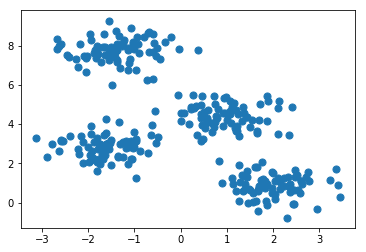

In [48]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

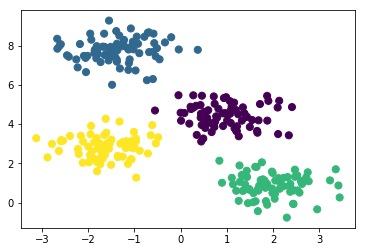

In [49]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);